In [122]:
global file
file = input('Selet a folder') ##enter your file path here - the file is in the repo "summary_stats.csv".
raw_file = file
##file

In [123]:
from datetime import datetime
from datetime import date
from subgrounds.subgraph import SyntheticField, FieldPath
from subgrounds.subgrounds import Subgrounds
import math
import pandas as pd
import  os as os
import duckdb as db
import seaborn as sns
import matplotlib.pyplot as plt

In [124]:
sg = Subgrounds()
snapshot = sg.load_api('https://hub.snapshot.org/graphql')

In [125]:
snapshot.Proposal.datetime = SyntheticField(
  lambda timestamp: str(datetime.fromtimestamp(timestamp)),
  SyntheticField.STRING,
  snapshot.Proposal.end,
)

In [126]:
spacename = input('spacename plz?')
proposals = snapshot.Query.proposals(
  orderBy='created',
  orderDirection='desc',
  first=10000,
  where=[
    snapshot.Proposal.space == spacename, ##'fuse.eth',
    snapshot.Proposal.state == 'closed'
    ##snapshot.Proposal.title == 'OIP-18: Reward rate framework and reduction',
  ]
)

In [127]:
proposals_snapshots = sg.query_df([
    proposals.title,
    proposals.id,
    proposals.body,
    proposals.scores,
    proposals.scores_total
])

In [128]:
proposals_choices = sg.query(proposals.choices)

In [129]:
proposals_choices = pd.DataFrame(proposals_choices)
##proposals_choices = pd.DataFrame(proposals_choices, columns = ['option_1', 'option_2', 'option_3', 'option_4', 'option_5','option_6','option_7','option_8','option_9','option_10','option_11','option_12','option_13','option_14','option_15','option_16','option_17','option_18','option_19','option_20','option_21','option_22'])

In [130]:
olympus_governance_view = pd.concat([proposals_snapshots,proposals_choices], axis=1)

In [131]:
olympus_governance_view

,proposals_title,proposals_id,proposals_body,proposals_scores,proposals_scores_total,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,CIP-69 Q3 Guild Structure and Budget,0x2b54d9b32411103a6d55d9efe74500a60b123d9250d1...,"## Citizens, \n\nThe following is a proposal f...",313,320,APPROVE,REJECT,None,None,None,None,None,None,None,None,None,None,None,None,None
1,CIP-69 Q3 Guild Structure and Budget,0x2b54d9b32411103a6d55d9efe74500a60b123d9250d1...,"## Citizens, \n\nThe following is a proposal f...",7,320,APPROVE,REJECT,None,None,None,None,None,None,None,None,None,None,None,None,None
2,CIP-102: Acquire Baby Parcel for NFT Leases,0x2f258399b295a8f8e9a35dbaa060b9cd8960fd2cdd7f...,## Proposal full text:\nhttps://forum.citydao....,342,353,Approve,Reject,None,None,None,None,None,None,None,None,None,None,None,None,None
3,CIP-102: Acquire Baby Parcel for NFT Leases,0x2f258399b295a8f8e9a35dbaa060b9cd8960fd2cdd7f...,## Proposal full text:\nhttps://forum.citydao....,11,353,Approve,Reject,None,None,None,None,None,None,None,None,None,None,None,None,None
4,CIP-63: CityDAO Parcel Home,bafkreiem3is7kq2w3g3lnxn3npheu6u7kmirnldrfgpsk...,TL/DR: This proposal authorizes up to $650k fo...,287,927,Approve,Reject,None,None,None,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,How many initial land parcel NFTs should we ma...,QmUf17vQtnbgS2o2v9sEGsz5QFfgBoKqVKXPsMjq1p2UTh,We will be able to acquire 5 - 50 acres of lan...,5,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95,How many initial land parcel NFTs should we ma...,QmUf17vQtnbgS2o2v9sEGsz5QFfgBoKqVKXPsMjq1p2UTh,We will be able to acquire 5 - 50 acres of lan...,35,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,How many initial land parcel NFTs should we ma...,QmUf17vQtnbgS2o2v9sEGsz5QFfgBoKqVKXPsMjq1p2UTh,We will be able to acquire 5 - 50 acres of lan...,4,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,Shall we adopt the following budget?,QmYFsHd2xMNxidhiwkdxKLyXBAztVN7Zmb1ojwD8h7RAMn,"The CityDAO treasury has about $250k, mainly g...",31,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [132]:
##let's view the output just to make sure
olympus_governance_view

,proposals_title,proposals_id,proposals_body,proposals_scores,proposals_scores_total,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,CIP-69 Q3 Guild Structure and Budget,0x2b54d9b32411103a6d55d9efe74500a60b123d9250d1...,"## Citizens, \n\nThe following is a proposal f...",313,320,APPROVE,REJECT,None,None,None,None,None,None,None,None,None,None,None,None,None
1,CIP-69 Q3 Guild Structure and Budget,0x2b54d9b32411103a6d55d9efe74500a60b123d9250d1...,"## Citizens, \n\nThe following is a proposal f...",7,320,APPROVE,REJECT,None,None,None,None,None,None,None,None,None,None,None,None,None
2,CIP-102: Acquire Baby Parcel for NFT Leases,0x2f258399b295a8f8e9a35dbaa060b9cd8960fd2cdd7f...,## Proposal full text:\nhttps://forum.citydao....,342,353,Approve,Reject,None,None,None,None,None,None,None,None,None,None,None,None,None
3,CIP-102: Acquire Baby Parcel for NFT Leases,0x2f258399b295a8f8e9a35dbaa060b9cd8960fd2cdd7f...,## Proposal full text:\nhttps://forum.citydao....,11,353,Approve,Reject,None,None,None,None,None,None,None,None,None,None,None,None,None
4,CIP-63: CityDAO Parcel Home,bafkreiem3is7kq2w3g3lnxn3npheu6u7kmirnldrfgpsk...,TL/DR: This proposal authorizes up to $650k fo...,287,927,Approve,Reject,None,None,None,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,How many initial land parcel NFTs should we ma...,QmUf17vQtnbgS2o2v9sEGsz5QFfgBoKqVKXPsMjq1p2UTh,We will be able to acquire 5 - 50 acres of lan...,5,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95,How many initial land parcel NFTs should we ma...,QmUf17vQtnbgS2o2v9sEGsz5QFfgBoKqVKXPsMjq1p2UTh,We will be able to acquire 5 - 50 acres of lan...,35,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,How many initial land parcel NFTs should we ma...,QmUf17vQtnbgS2o2v9sEGsz5QFfgBoKqVKXPsMjq1p2UTh,We will be able to acquire 5 - 50 acres of lan...,4,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,Shall we adopt the following budget?,QmYFsHd2xMNxidhiwkdxKLyXBAztVN7Zmb1ojwD8h7RAMn,"The CityDAO treasury has about $250k, mainly g...",31,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [133]:
olympus_governance_view_clean = olympus_governance_view.copy(deep=True)
olympus_governance_view_clean.insert(0, 'DAO', spacename)
olympus_governance_view_clean

,DAO,proposals_title,proposals_id,proposals_body,proposals_scores,proposals_scores_total,0,1,2,3,...,5,6,7,8,9,10,11,12,13,14
0,daocity.eth,CIP-69 Q3 Guild Structure and Budget,0x2b54d9b32411103a6d55d9efe74500a60b123d9250d1...,"## Citizens, \n\nThe following is a proposal f...",313,320,APPROVE,REJECT,None,None,...,None,None,None,None,None,None,None,None,None,None
1,daocity.eth,CIP-69 Q3 Guild Structure and Budget,0x2b54d9b32411103a6d55d9efe74500a60b123d9250d1...,"## Citizens, \n\nThe following is a proposal f...",7,320,APPROVE,REJECT,None,None,...,None,None,None,None,None,None,None,None,None,None
2,daocity.eth,CIP-102: Acquire Baby Parcel for NFT Leases,0x2f258399b295a8f8e9a35dbaa060b9cd8960fd2cdd7f...,## Proposal full text:\nhttps://forum.citydao....,342,353,Approve,Reject,None,None,...,None,None,None,None,None,None,None,None,None,None
3,daocity.eth,CIP-102: Acquire Baby Parcel for NFT Leases,0x2f258399b295a8f8e9a35dbaa060b9cd8960fd2cdd7f...,## Proposal full text:\nhttps://forum.citydao....,11,353,Approve,Reject,None,None,...,None,None,None,None,None,None,None,None,None,None
4,daocity.eth,CIP-63: CityDAO Parcel Home,bafkreiem3is7kq2w3g3lnxn3npheu6u7kmirnldrfgpsk...,TL/DR: This proposal authorizes up to $650k fo...,287,927,Approve,Reject,None,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,daocity.eth,How many initial land parcel NFTs should we ma...,QmUf17vQtnbgS2o2v9sEGsz5QFfgBoKqVKXPsMjq1p2UTh,We will be able to acquire 5 - 50 acres of lan...,5,44,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95,daocity.eth,How many initial land parcel NFTs should we ma...,QmUf17vQtnbgS2o2v9sEGsz5QFfgBoKqVKXPsMjq1p2UTh,We will be able to acquire 5 - 50 acres of lan...,35,44,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,daocity.eth,How many initial land parcel NFTs should we ma...,QmUf17vQtnbgS2o2v9sEGsz5QFfgBoKqVKXPsMjq1p2UTh,We will be able to acquire 5 - 50 acres of lan...,4,44,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,daocity.eth,Shall we adopt the following budget?,QmYFsHd2xMNxidhiwkdxKLyXBAztVN7Zmb1ojwD8h7RAMn,"The CityDAO treasury has about $250k, mainly g...",31,32,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [134]:
path =file+'/'+spacename+'_proposals_table_'+str(date.today().strftime("%b-%d-%Y"))+'_'+str(len(olympus_governance_view))+'_proposals.csv'
olympus_governance_view.to_csv(path, index = False)

In [135]:
total_proposals = len(olympus_governance_view)
total_proposals

99

In [136]:
proposal_id = olympus_governance_view.iloc[0,1]

In [137]:
print(proposal_id)

0x2b54d9b32411103a6d55d9efe74500a60b123d9250d1f3fd72d32f60ed19a657


In [138]:

vote_tracker = snapshot.Query.votes(
orderBy = 'created',
orderDirection='desc',
first=10000,
where=[
  snapshot.Vote.proposal == proposal_id
]
)

In [139]:
voting_snapshots_list = sg.query_df([
    vote_tracker.id,
    vote_tracker.voter,
    vote_tracker.created,
    vote_tracker.choice,
    vote_tracker.vp
])

In [140]:
voting_snapshots_list

,votes_id,votes_voter,votes_created,votes_choice,votes_vp
0,0xb1c0bfbb422a6583f95ec3d90ebc438e62872b7c3593...,0xf51c7e2C8f72DCdF40c6272729996976AEFaFAEB,1658699675,1,2
1,0xb60bc744c96c1c9091c2d4b77b06cc80eebf524f9c47...,0xE36E470e4347f35EdEcd82F38Dc2647CDe0C16fD,1658696275,1,1
2,0x8e7dbaf89a7f194083cada3f14929879611fb8532133...,0x50Ad2BA3AeB280aBfe8699f5Ac4E11e1482967f6,1658679851,1,1
3,0x36a52898feba7621aeb743fbe4bbfbbbcb4af84064a5...,0x36398D9CEE405386b9b93DE1445d325C254F035e,1658679685,1,1
4,0xd789011956f6c09a14a6d302ac3a56210d396787c8c9...,0xb702488a6C08E34c6E3274367392Fc75B1321346,1658678350,1,1
...,...,...,...,...,...
260,0x0ed19bf14244d5a1afcdaeded43d9a8474ec4c1aa092...,0x30C1996ce32BCe9f02EF8DB7F27BF08E39c224e7,1658108247,1,1
261,0xdd34902ad7fc9f29b0a9ce8d887468f182dcb456f6e1...,0x43eD63322703Ca6249DDD5A094D9bee0A3E8aaF7,1658106569,1,1
262,bafkreihabyjy4hcip4zee4l3cch3bxqf2hi4skluu5mqp...,0x029257116E5a4343b63EaCea31A8955dDa266D8F,1658106289,1,1
263,0xba683f53937b5263845c393e98b2a0ab3111189454be...,0xc1B111fFD6C3A1Bee0e58eD771739Db091C95977,1658105766,1,1


In [141]:
voting_snapshots_list['Proposal'] = proposal_id
proposal_id

'0x2b54d9b32411103a6d55d9efe74500a60b123d9250d1f3fd72d32f60ed19a657'

In [142]:
x=0
while x <total_proposals:
    proposal_id = olympus_governance_view.iloc[x,1]

    vote_tracker = snapshot.Query.votes(
    orderBy = 'created',
    orderDirection='desc',
    first=10000,
    where=[
      snapshot.Vote.proposal == proposal_id
    ]
    )
    voting_snapshots = sg.query_df([
    vote_tracker.id,
    vote_tracker.voter,
    vote_tracker.created,
    vote_tracker.choice,
    vote_tracker.vp
    ])

    voting_snapshots['Proposal'] = proposal_id
    voting_snapshots_list=pd.concat([voting_snapshots_list, voting_snapshots])

    x=x+1
    progress = 100*(round(x/total_proposals,4))
    ##clear_output(wait=True)
    if progress%5==0:
        print("Progress",progress,"%")

Progress 100.0 %


In [143]:
len(voting_snapshots_list)

76379

In [144]:
path =file+'/'+spacename+'_voting_snapshots_list_'+str(date.today().strftime("%b-%d-%Y"))+'_'+str(len(olympus_governance_view))+'.csv'
voting_snapshots_list.to_csv(path, index = False)

In [145]:
governance_data = pd.merge(voting_snapshots_list, olympus_governance_view, how='inner', left_on='Proposal', right_on='proposals_id')
del governance_data["proposals_body"]
governance_data

,votes_id,votes_voter,votes_created,votes_choice,votes_vp,Proposal,proposals_title,proposals_id,proposals_scores,proposals_scores_total,...,5,6,7,8,9,10,11,12,13,14
0,0xb1c0bfbb422a6583f95ec3d90ebc438e62872b7c3593...,0xf51c7e2C8f72DCdF40c6272729996976AEFaFAEB,1658699675,1,2,0x2b54d9b32411103a6d55d9efe74500a60b123d9250d1...,CIP-69 Q3 Guild Structure and Budget,0x2b54d9b32411103a6d55d9efe74500a60b123d9250d1...,313,320,...,None,None,None,None,None,None,None,None,None,None
1,0xb1c0bfbb422a6583f95ec3d90ebc438e62872b7c3593...,0xf51c7e2C8f72DCdF40c6272729996976AEFaFAEB,1658699675,1,2,0x2b54d9b32411103a6d55d9efe74500a60b123d9250d1...,CIP-69 Q3 Guild Structure and Budget,0x2b54d9b32411103a6d55d9efe74500a60b123d9250d1...,7,320,...,None,None,None,None,None,None,None,None,None,None
2,0xb60bc744c96c1c9091c2d4b77b06cc80eebf524f9c47...,0xE36E470e4347f35EdEcd82F38Dc2647CDe0C16fD,1658696275,1,1,0x2b54d9b32411103a6d55d9efe74500a60b123d9250d1...,CIP-69 Q3 Guild Structure and Budget,0x2b54d9b32411103a6d55d9efe74500a60b123d9250d1...,313,320,...,None,None,None,None,None,None,None,None,None,None
3,0xb60bc744c96c1c9091c2d4b77b06cc80eebf524f9c47...,0xE36E470e4347f35EdEcd82F38Dc2647CDe0C16fD,1658696275,1,1,0x2b54d9b32411103a6d55d9efe74500a60b123d9250d1...,CIP-69 Q3 Guild Structure and Budget,0x2b54d9b32411103a6d55d9efe74500a60b123d9250d1...,7,320,...,None,None,None,None,None,None,None,None,None,None
4,0x8e7dbaf89a7f194083cada3f14929879611fb8532133...,0x50Ad2BA3AeB280aBfe8699f5Ac4E11e1482967f6,1658679851,1,1,0x2b54d9b32411103a6d55d9efe74500a60b123d9250d1...,CIP-69 Q3 Guild Structure and Budget,0x2b54d9b32411103a6d55d9efe74500a60b123d9250d1...,313,320,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
648345,QmahdyC4m575gUB2k2DiX2dggByLjX5BP2uzH6iHEbXS9r,0x1200Eb4fA3dF9903fC6EfF1d7A4a5D17502329b2,1630438742,1,1,QmYFsHd2xMNxidhiwkdxKLyXBAztVN7Zmb1ojwD8h7RAMn,Shall we adopt the following budget?,QmYFsHd2xMNxidhiwkdxKLyXBAztVN7Zmb1ojwD8h7RAMn,1,32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
648346,QmeYKtwuVuAvny2RjgKw6AfiEfr7Qnvt9mZWwrStGW5Gwq,0xEd24226381F5144562f0F50C69b7AbBAf5a2F093,1630438699,1,1,QmYFsHd2xMNxidhiwkdxKLyXBAztVN7Zmb1ojwD8h7RAMn,Shall we adopt the following budget?,QmYFsHd2xMNxidhiwkdxKLyXBAztVN7Zmb1ojwD8h7RAMn,31,32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
648347,QmeYKtwuVuAvny2RjgKw6AfiEfr7Qnvt9mZWwrStGW5Gwq,0xEd24226381F5144562f0F50C69b7AbBAf5a2F093,1630438699,1,1,QmYFsHd2xMNxidhiwkdxKLyXBAztVN7Zmb1ojwD8h7RAMn,Shall we adopt the following budget?,QmYFsHd2xMNxidhiwkdxKLyXBAztVN7Zmb1ojwD8h7RAMn,1,32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
648348,QmQY5qwLwnASByprnsgVNpHbuhGCzu6vVsS6X6x5L4SAbi,0x267a3195ea57ad38E65993DBcB9FBebf8995621D,1630436580,1,1,QmYFsHd2xMNxidhiwkdxKLyXBAztVN7Zmb1ojwD8h7RAMn,Shall we adopt the following budget?,QmYFsHd2xMNxidhiwkdxKLyXBAztVN7Zmb1ojwD8h7RAMn,31,32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [146]:
final_file = file+'\\'+'final'
final_raw_file = final_file

In [147]:
os.makedirs(final_raw_file, exist_ok=True)

In [148]:
final_path =file+'\\'+spacename+'governance_data_'+str(date.today().strftime("%b-%d-%Y"))+'_'+str(len(governance_data))+'.csv'

In [149]:
governance_data.to_csv(final_path, index = False)

In [150]:
crunch_data = db.query("select "
                           "Proposal"
                           ",votes_voter "
                           ",votes_choice"
                           ",votes_vp"
                           ",votes_created"
                           ",sum(votes_vp) over (Partition by Proposal  order by votes_vp desc, votes_created asc) as cumulative_vp"
                           ",sum(votes_vp) over (Partition by Proposal) as total_vp"
                           ",(votes_vp::decimal/sum(votes_vp::decimal) over (Partition by Proposal)) as percentange_of_total_vp "
                           ",((sum(votes_vp) over (Partition by Proposal  order by votes_vp desc, votes_created asc))::decimal/sum(votes_vp::decimal) over (Partition by Proposal)) as cum_percentange_of_total_vp "
                       ",round((sum(votes_vp) over (Partition by Proposal  order by votes_vp desc, votes_created asc))::decimal/sum(votes_vp::decimal) over (Partition by Proposal)) as cum_percentange_of_total_vp_stepped "
                           ",row_number() over (Partition by Proposal order by votes_vp desc, votes_created asc) as proposal_voter_rank "
                           ",count(votes_voter) over (Partition by Proposal  order by votes_vp desc, votes_created asc) voters_counted "
                           ",(count(*) over (Partition by Proposal  order by votes_vp desc, votes_created asc))::decimal/(count(*) over (Partition by Proposal))::decimal percentage_voters_counted "
                           ",round(100*(count(*) over (Partition by Proposal  order by votes_vp desc, votes_created asc))::decimal/(count(*) over (Partition by Proposal)))::decimal percentage_voters_counted_stepped "
                       "from "
                       "    governance_data  "
                       ""
                       "Group by "
                       "    Proposal"
                       "    ,votes_voter"
                       "    ,votes_choice"
                       "    , votes_vp "
                       "    , votes_created "
                       ""
                       "Order by "
                       "    Proposal, "
                       "    votes_vp desc "
                       "    , votes_created asc"
                       "").df()


crunch_data.insert(0, 'DAO', spacename)
crunch_data.head(n=10)

,DAO,Proposal,votes_voter,votes_choice,votes_vp,votes_created,cumulative_vp,total_vp,percentange_of_total_vp,cum_percentange_of_total_vp,cum_percentange_of_total_vp_stepped,proposal_voter_rank,voters_counted,percentage_voters_counted,percentage_voters_counted_stepped
0,daocity.eth,0x03fa9dd24efa6b64f3f05b1b55b794d9c8b2de98ee82...,0x3B78Fcf6128D8903b4bDaB1e25244578b5A7676F,1,11,1652721007,11.0,562.0,0.019573,0.019573,0.0,1,1,0.002625,0.0
1,daocity.eth,0x03fa9dd24efa6b64f3f05b1b55b794d9c8b2de98ee82...,0x3Fa79813b7b271f840b2242ed218E8235c3cAb5B,1,10,1653063853,21.0,562.0,0.017794,0.037367,0.0,2,2,0.005249,1.0
2,daocity.eth,0x03fa9dd24efa6b64f3f05b1b55b794d9c8b2de98ee82...,0x1C099682502Bd3b4767828ffAFf975FAc340C0ab,1,8,1652763703,29.0,562.0,0.014235,0.051601,0.0,3,3,0.007874,1.0
3,daocity.eth,0x03fa9dd24efa6b64f3f05b1b55b794d9c8b2de98ee82...,0x9d4e96276F79F6FDFC3131588f0e58cD59491C9d,1,8,1652766905,37.0,562.0,0.014235,0.065836,0.0,4,4,0.010499,1.0
4,daocity.eth,0x03fa9dd24efa6b64f3f05b1b55b794d9c8b2de98ee82...,0xf87694eEEC1ced7c1136Cba56Dc21B414957d62b,2,8,1652838781,45.0,562.0,0.014235,0.080071,0.0,5,5,0.013123,1.0
5,daocity.eth,0x03fa9dd24efa6b64f3f05b1b55b794d9c8b2de98ee82...,0x67a06A59Fd7B8BB2ebf3aB5d33704Fd323e60a47,2,8,1653299045,53.0,562.0,0.014235,0.094306,0.0,6,6,0.015748,2.0
6,daocity.eth,0x03fa9dd24efa6b64f3f05b1b55b794d9c8b2de98ee82...,0x74C160e7b7FF01E32277FfB8162DcdE635a72061,1,7,1652835151,60.0,562.0,0.012456,0.106762,0.0,7,7,0.018373,2.0
7,daocity.eth,0x03fa9dd24efa6b64f3f05b1b55b794d9c8b2de98ee82...,0x7cfa9d7B8F302347aE557dD38b77fa110bBC1551,1,6,1652840693,66.0,562.0,0.010676,0.117438,0.0,8,8,0.020997,2.0
8,daocity.eth,0x03fa9dd24efa6b64f3f05b1b55b794d9c8b2de98ee82...,0x90Cf5124D8dcECF9d4d5314Cd986Cde622A5FAE3,2,6,1652856603,72.0,562.0,0.010676,0.128114,0.0,9,9,0.023622,2.0
9,daocity.eth,0x03fa9dd24efa6b64f3f05b1b55b794d9c8b2de98ee82...,0x77aA943A365161e499eaFF59E936a799e6051e15,1,6,1653219324,78.0,562.0,0.010676,0.138790,0.0,10,10,0.026247,3.0


In [151]:
##spit out the file!
crunch_data_path =final_file+'\\'+spacename+'_crunch_data_path'+str(date.today().strftime("%b-%d-%Y"))+'_'+str(len(crunch_data))+'.csv'

crunch_data.to_csv(crunch_data_path, index = False)

In [152]:
print('done')

done


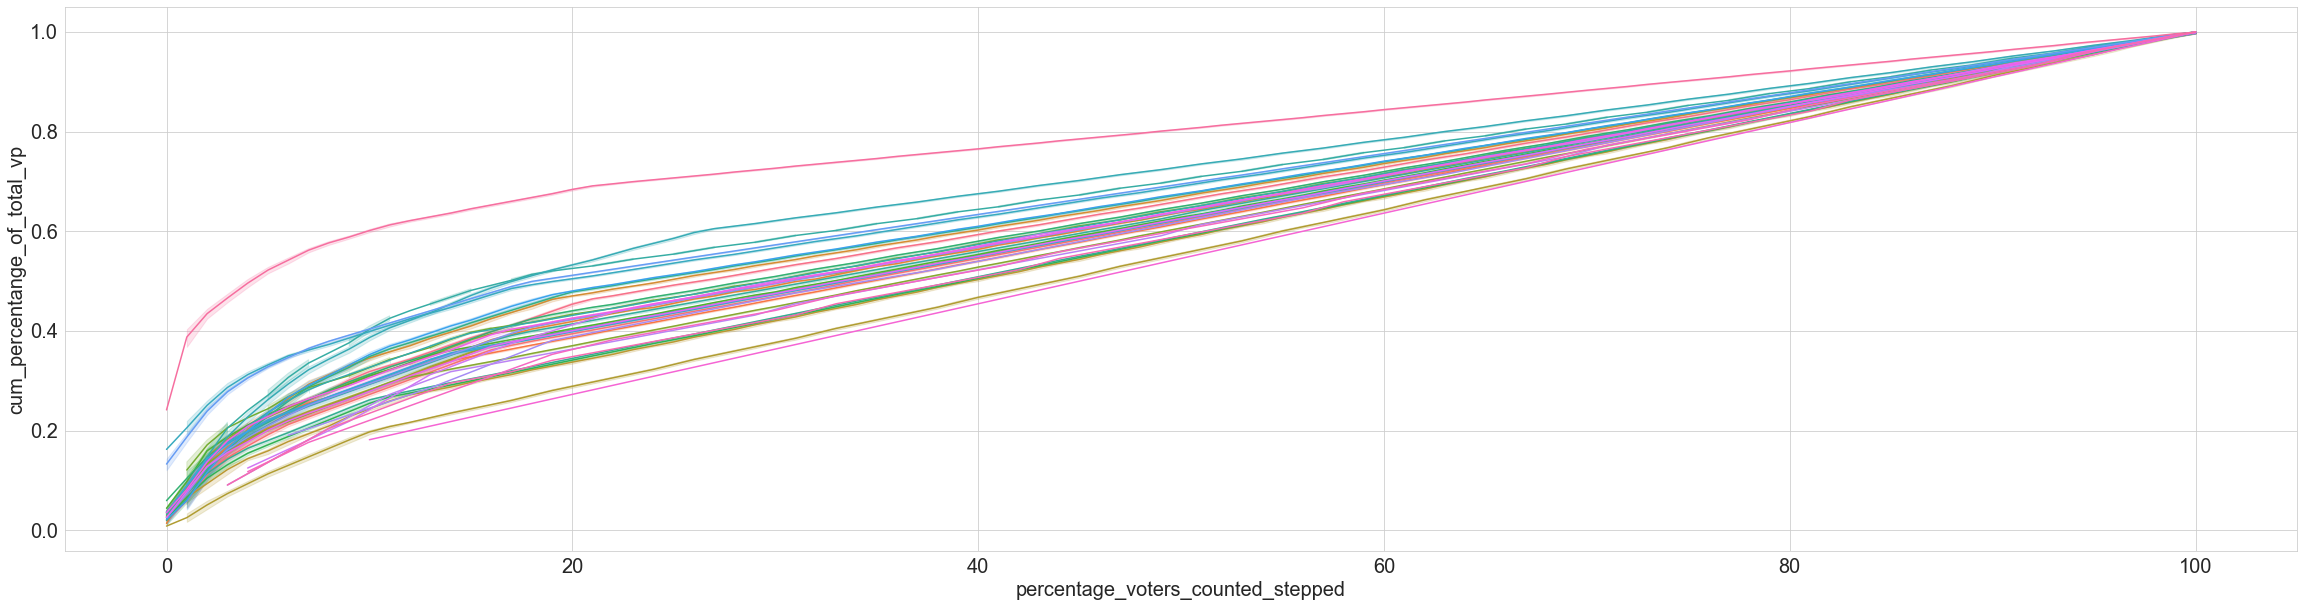

In [153]:
plt.rc("figure", figsize=(40, 10))
plt.rc("font", size=20)

sns.lineplot(data=crunch_data, y="cum_percentange_of_total_vp",x="percentage_voters_counted_stepped", hue="Proposal")
plt.legend([],[], frameon=False)

In [154]:
##sns.boxplot(data=crunch_data, y="cum_percentange_of_total_vp",x="percentage_voters_counted")
##plt.legend([],[], frameon=False)

     percentage_voters_counted_stepped  cum_percentange_of_total_vp
0                                  0.0                     0.046279
1                                  1.0                     0.096771
2                                  2.0                     0.148076
3                                  3.0                     0.177506
4                                  4.0                     0.204252
..                                 ...                          ...
96                                96.0                     0.970936
97                                97.0                     0.978112
98                                98.0                     0.985639
99                                99.0                     0.992968
100                              100.0                     0.998595

[101 rows x 2 columns]


<AxesSubplot:xlabel='percentage_voters_counted_stepped', ylabel='cum_percentange_of_total_vp'>

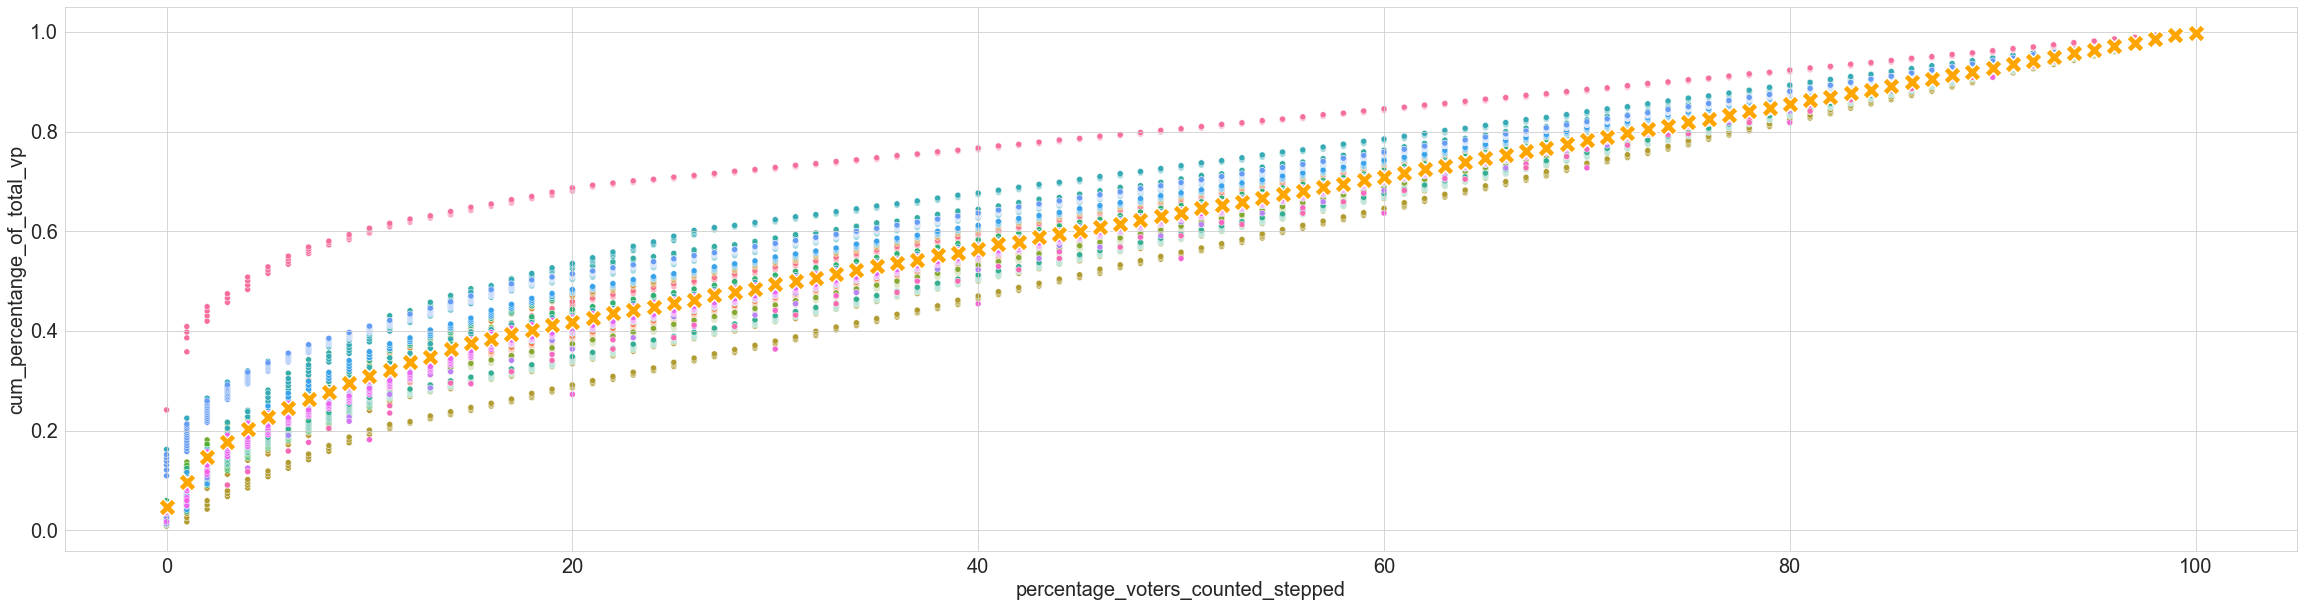

In [155]:
data_means = crunch_data.groupby("percentage_voters_counted_stepped")["cum_percentange_of_total_vp"].agg("mean").reset_index()
print(data_means)
sns.set_style("whitegrid")
ax=sns.scatterplot(data=data_means,x="percentage_voters_counted_stepped",y="cum_percentange_of_total_vp", s=300,marker='X',color = 'orange', legend=False)
sns.scatterplot(data=crunch_data, y="cum_percentange_of_total_vp",x="percentage_voters_counted_stepped", hue="Proposal",zorder=-3, legend=False)